In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re, string
import nltk
from sklearn.model_selection import train_test_split
import gensim
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow import keras

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package stopwords to /home/km/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/km/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_df = pd.read_csv("train.csv", dtype={'id': int, "keyword":str, 'location':str, "text":str, 'target':int}, na_filter=False)
test_df = pd.read_csv("test.csv", dtype={'id': int, "keyword":str, 'location':str, "text":str}, na_filter=False)
submission = pd.read_csv("sample_submission.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,,,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
def strip_links(text):
    links_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(links_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text.lower()

In [7]:
import string
def strip_all_entities(text):
    text = strip_links(text)
    entity_prefixes = ['@']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, ' ')
    words = []
    for word in text.split():
        word = word.strip().lower()
        if word:
            if word[0] not in entity_prefixes:
                if not word.isdigit():
                    words.append(word)
    return ' '.join(words)

In [8]:
train_df['text_with_key'] = train_df['text'] + train_df['keyword']
train_df.head()
test_df['text_with_key'] = test_df['text'] + test_df['keyword']
test_df.head()

,id,keyword,location,text,text_with_key
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s..."
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df['stopwords'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train_df['stop'] = train_df['stopwords'].apply(lambda x: strip_all_entities(x))
train_df.head()

,id,keyword,location,text,target,text_with_key,stopwords,stop
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds Reason #earthquake May ALLAH Forgive us,our deeds reason earthquake may allah forgive us
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,All residents asked 'shelter place' notified o...,all residents asked shelter place notified off...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Just got sent photo Ruby #Alaska smoke #wildfi...,just got sent photo ruby alaska smoke wildfire...


In [10]:
test_df['stopwords'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['stop'] = test_df['stopwords'].apply(lambda x: strip_all_entities(x))
test_df.head()

,id,keyword,location,text,text_with_key,stopwords,stop
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash,Just happened terrible car crash,just happened terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...","Heard #earthquake different cities, stay safe ...",heard earthquake different cities stay safe ev...
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","forest fire spot pond, geese fleeing across st...",forest fire spot pond geese fleeing across str...
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 China Taiwan,typhoon soudelor kills china taiwan


In [11]:
from collections import Counter
word_dict = Counter(" ".join(train_df['stop'].values.tolist()).split()).items()
vocab_size = len(word_dict)
print(vocab_size)

14995


In [12]:
input_length = len(train_df)
print(input_length)

7613


In [13]:
max_length=28
text_train = [sentence.lower().split() for sentence in train_df['stop']]
text_test = [sentence.lower().split() for sentence in test_df['stop']]
print(text_train)

[['our', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], ['all', 'residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'no', 'evacuation', 'shelter', 'place', 'orders', 'expected'], ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'], ['just', 'got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school'], ['rockyfire', 'update', 'california', 'hwy', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires'], ['flood', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'streets', 'manitou', 'colorado', 'springs', 'areas'], ['i', 'm', 'top', 'hill', 'i', 'see', 'fire', 'woods'], ['there', 's', 'emergency', 'evacuation', 'happening', 'building', 'across', 'street'], ['i', 'm', 'afraid', 'tornado', 'coming', 'area'], ['three', 'people', 'died', 'heat', 'wave', 'far'], ['haha', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait

In [14]:
word_size=300
workers=4
min_word_count=3
iters=10
window_size=6
sampling=1e-3
#word_model = gensim.models.Word2Vec(text_train, workers=workers, size=word_size, min_count=min_word_count, iter=iters, window=window_size, sample=sampling)
#word_model.init_sims(replace=True)
word_model = gensim.models.FastText(text_train, workers=workers, size=word_size, min_count=min_word_count, sg=1)

embedding_matrix=np.zeros((len(word_model.wv.vocab) +1, word_size))
for i, vec in enumerate(word_model.wv.vectors):
    embedding_matrix[i] = vec

In [15]:
word_model.wv.most_similar('earthquake')

[('apocalypse', 0.9999183416366577),
 ('earth', 0.9999176859855652),
 ('ablaze', 0.9999175071716309),
 ('palms', 0.9999161958694458),
 ('ap', 0.999915599822998),
 ('asap', 0.999902606010437),
 ('patrick', 0.9999008774757385),
 ('clip', 0.9998987317085266),
 ('brooklyn', 0.999898374080658),
 ('apc', 0.9998983144760132)]

In [16]:
features=500
tokenizer = Tokenizer(num_words = features)
tokenizer.fit_on_texts(text_train)
word_index = tokenizer.word_index
X_train = tokenizer.texts_to_sequences(text_train)
X_train = pad_sequences(X_train)
X_test = tokenizer.texts_to_sequences(text_test)
X_test = pad_sequences(X_test)
print(len(X_test))

3263


In [17]:
print(len(word_model.wv.vocab))

4341


In [18]:
model = Sequential([
    tf.keras.layers.Embedding(len(word_model.wv.vocab)+1,word_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(word_size)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         1302600   
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 2,745,601
Trainable params: 2,745,601
Non-trainable params: 0
_________________________________________________________________


In [19]:
#model = Sequential([
#    tf.keras.layers.Embedding(vocab_size, 32),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#    tf.keras.layers.Dense(32, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
target = np.array(train_df['target'])
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(X_train, target, test_size=0.2)
print(len(input_tensor_train))
print(len(input_tensor_val))
print(len(target_tensor_train))
print(len(target_tensor_val))

6090
1523
6090
1523


In [22]:
epochs=15
history = model.fit(x=input_tensor_train, y=target_tensor_train, epochs=epochs, validation_data=(input_tensor_val,target_tensor_val), validation_steps=20)

Train on 6090 samples, validate on 1523 samples
Epoch 1/15
6090/6090 [==============================] - 9s 1ms/sample - loss: 0.6658 - accuracy: 0.5992 - val_loss: 0.2586 - val_accuracy: 0.6984
Epoch 2/15
6090/6090 [==============================] - 3s 515us/sample - loss: 0.4957 - accuracy: 0.7673 - val_loss: 0.2052 - val_accuracy: 0.7625
Epoch 3/15
6090/6090 [==============================] - 3s 511us/sample - loss: 0.4531 - accuracy: 0.7933 - val_loss: 0.2025 - val_accuracy: 0.7828
Epoch 4/15
6090/6090 [==============================] - 3s 521us/sample - loss: 0.4371 - accuracy: 0.8038 - val_loss: 0.2017 - val_accuracy: 0.7688
Epoch 5/15
6090/6090 [==============================] - 3s 520us/sample - loss: 0.4303 - accuracy: 0.8123 - val_loss: 0.2033 - val_accuracy: 0.7641
Epoch 6/15
6090/6090 [==============================] - 3s 520us/sample - loss: 0.4248 - accuracy: 0.8140 - val_loss: 0.2020 - val_accuracy: 0.7797
Epoch 7/15
6090/6090 [==============================] - 3s 521us/s

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

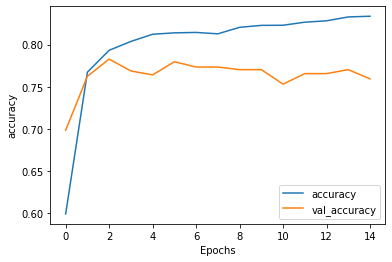

In [24]:
plot_graphs(history, 'accuracy')

In [25]:
predictions=model.predict(X_test)

In [26]:
predictions

array([[0.86021745],
       [0.70234877],
       [0.534951  ],
       ...,
       [0.89512074],
       [0.7244475 ],
       [0.4252684 ]], dtype=float32)

In [27]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [28]:
submission['target'] = (predictions > 0.5).astype(int)

In [29]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [30]:
submission.to_csv("submission.csv", index=False, header=True)